## TF-IDF (Term frequency-Inverse Document Frequency) recommendation 

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

data = pd.read_csv("arxiv_metadata_final.csv")

data.head()


,id,title,abstract,categories,authors
0,704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,hep-ph,C. Bal\'azs; E. L. Berger; P. M. Nadolsky; C.-...
1,704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",math.CO; cs.CG,Ileana Streinu and Louis Theran
2,704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,physics.gen-ph,Hongjun Pan
3,704.0004,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...,math.CO,David Callan
4,704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...,math.CA; math.FA,Wael Abu-Shammala and Alberto Torchinsky


In [3]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['abstract'])


In [4]:
# Cosine similarity

query_index = 42
query_vector = tfidf_matrix[query_index]
cosine_similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
similar_indices = cosine_similarities.argsort()[::-1][1:6] 
similar_scores = cosine_similarities[similar_indices]


In [5]:
for idx, score in zip(similar_indices, similar_scores):
    print(f"\n--- Paper #{idx} (Similarity: {score:.3f}) ---")
    print(data.loc[idx, 'title'])
    print(data.loc[idx, 'categories'])
    print(data.loc[idx, 'abstract'])



--- Paper #8481 (Similarity: 0.292) ---
Nonequilibrium quantum-impurities: from entropy production to
  information theory
cond-mat.str-el; cond-mat.stat-mech
  Nonequilibrium steady-state currents, unlike their equilibrium counterparts,
continuously dissipate energy into their physical surroundings leading to
entropy production and time-reversal symmetry breaking. This letter discusses
these issues in the context of quantum impurity models driven out of
equilibrium by attaching the impurity to leads at different chemical potentials
and temperatures. We start by pointing out that entropy production is often
hidden in traditional treatments of quantum-impurity models. We then use simple
thermodynamic arguments to define the rate of entropy production. Using the
scattering framework recently developed by the authors we show that the rate of
entropy production has a simple information theoretic interpretation in terms
of the Shannon entropy and Kullback-Leibler divergence of nonequilibri

## NN (Neareast Neighbors) recommendation

In [6]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

/Users/human/Documents/codeop/moduleFelipa/insightminer/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
data = data.dropna(subset=['abstract'])

abstracts = data['abstract'].tolist()
embeddings = model.encode(abstracts, show_progress_bar=True)

Batches: 100%|██████████| 313/313 [00:42<00:00,  7.38it/s]


In [8]:
from sklearn.neighbors import NearestNeighbors

nn_model = NearestNeighbors(n_neighbors=6, metric='cosine')
nn_model.fit(embeddings)
query_idx = 42
query_vector = embeddings[query_idx].reshape(1, -1)
distances, indices = nn_model.kneighbors(query_vector)

In [9]:
for idx, dist in zip(indices[0][1:], distances[0][1:]): 
    print(f"\n--- Paper #{idx} (Distance: {dist:.3f}) ---")
    print(f"Title: {data.loc[idx, 'title']}")
    print(f"Categories: {data.loc[idx, 'categories']}")
    print(f"Abstract: {data.loc[idx, 'abstract']}")



--- Paper #8373 (Distance: 0.390) ---
Title: Stable simulation of fluid flow with high-Reynolds number using
  Ehrenfests' steps
Categories: cond-mat.stat-mech
Abstract:   The Navier--Stokes equations arise naturally as a result of Ehrenfests'
coarse-graining in phase space after a period of free-flight dynamics. This
point of view allows for a very flexible approach to the simulation of fluid
flow for high-Reynolds number. We construct regularisers for lattice Boltzmann
computational models. These regularisers are based on Ehrenfests'
coarse-graining idea and could be applied to schemes with either entropic or
non-entropic quasiequilibria. We give a numerical scheme which gives good
results for the standard test cases of the shock tube and the flow past a
square cylinder.


--- Paper #338 (Distance: 0.397) ---
Title: Lattice Boltzmann inverse kinetic approach for the incompressible
  Navier-Stokes equations
Categories: physics.flu-dyn; physics.comp-ph
Abstract:   In spite of the larg

## Extracting keywords and entities

In [10]:
from keybert import KeyBERT

keyword_model = KeyBERT(model="all-MiniLM-L6-v2")

In [ ]:
def extract_keywords(text, top_n=10):
    keywords = keyword_model.extract_keywords(text, top_n=top_n, stop_words='english')
    return [keyword for keyword, _ in keywords]

data['keywords'] = data['abstract'].apply(lambda x: extract_keywords(x))


## Vizualisation

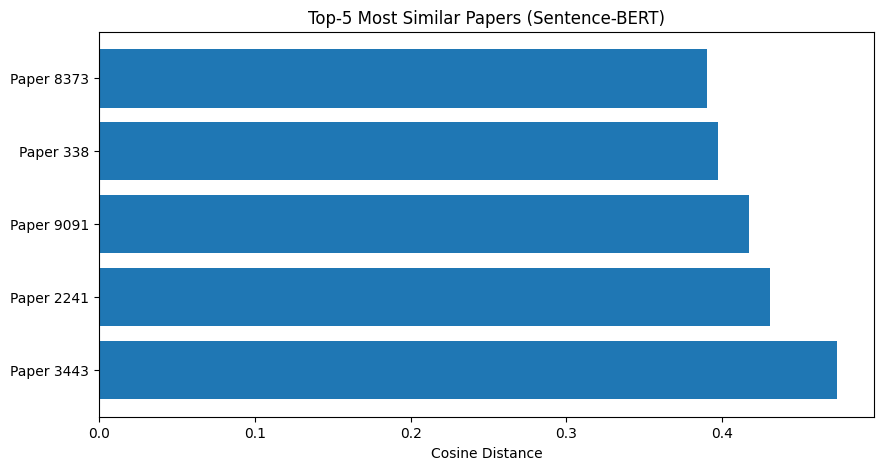

In [ ]:
import matplotlib.pyplot as plt

labels = [f"Paper {i}" for i in indices[0][1:6]]
values = distances[0][1:6]

plt.figure(figsize=(10, 5))
plt.barh(labels, values)
plt.xlabel("Cosine Distance")
plt.title("Top-5 Most Similar Papers (Sentence-BERT)")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

categories = data['categories'].astype(str).tolist()
main_categories = [cat.split()[0] for cat in categories]
unique_categories = list(set(main_categories))
palette = sns.color_palette("hls", len(unique_categories))
category_to_color = {cat: palette[i] for i, cat in enumerate(unique_categories)}


/var/folders/b3/zprflkgn32zbxl2l7xg90qsr0000gn/T/ipykernel_7038/299705600.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


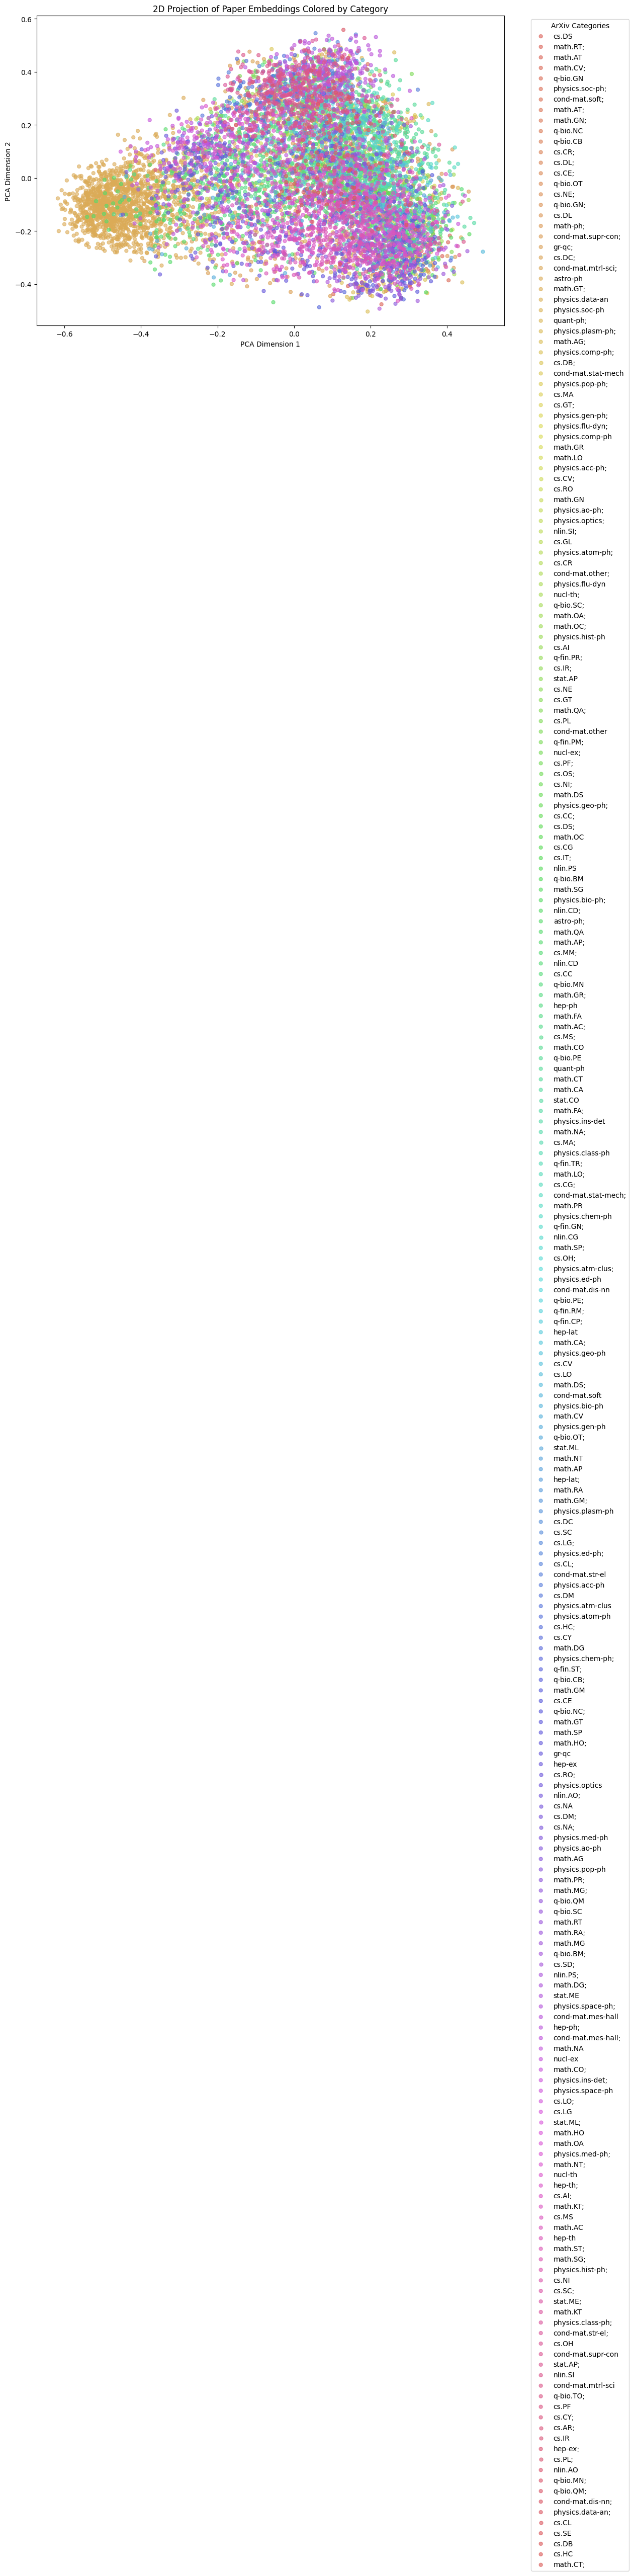

In [ ]:
plt.figure(figsize=(12, 8))

for cat in unique_categories:
    idxs = [i for i, c in enumerate(main_categories) if c == cat]
    plt.scatter(
        reduced[idxs, 0],
        reduced[idxs, 1],
        label=cat,
        c=[category_to_color[cat]] * len(idxs),
        alpha=0.6,
        s=25
    )

plt.legend(title="ArXiv Categories", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("2D Projection of Paper Embeddings Colored by Category")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.tight_layout()
plt.show()
